In [47]:
import neutral_temp
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Data Preparation

## Import ASHRAE Global Thermal Comfort Database 2

In [157]:
# Read metadata and data from Github
df_meta = pd.read_csv("https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_metadata.csv")
df_measurements = pd.read_csv("https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_measurements_v2.1.0.csv.gz", low_memory=False)
# Merge metadata and measurement data by building_id
df_rawdata = df_measurements.merge(df_meta[['building_id', 'city', 'building_type', 'cooling_type', 'records', 'database']], on='building_id', how='left')
# Replace two outdoor temperature columns by a new column called t_out_combined
df_rawdata.loc[:, 't_out_combined'] = df_rawdata.loc[:, 't_out_isd'].fillna(df_rawdata.loc[:, 't_out'])
df_rawdata = df_rawdata.drop(columns=['t_out_isd', 't_out'])
print('Total buildings:', len(df_rawdata.building_id.unique()))
print('Total occupants:', len(df_rawdata))

Total buildings: 809
Total occupants: 109033


## Select occupants that have concurrent Top, TSV, and Tout data

In [160]:
df_data_1 = df_rawdata.dropna(subset=['top', 'thermal_sensation', 't_out_combined'])
print(f'Buildings without missing data:', len(df_data_1['building_id'].unique()))
print(f'Buildings occupants without missing data:', len(df_data_1))

Buildings without missing data: 553
Buildings occupants without missing data: 38467


## Group data by building ID, with mean values

In [59]:
# Group by 'building_id' and calculate the mean for all these columns at once
df_data_mean = df_data_1.groupby('building_id')[['t_out_combined', 'top', 'thermal_sensation']].mean()
# Reset the index of df_data_mean to make 'building_id' a column again
df_data_mean.reset_index(inplace=True)
# Merge df_data_mean with the metadata
df_bldg_1 = df_data_mean.merge(df_meta[['building_id', 'records', 'cooling_type', 'building_type', 'database']], on='building_id', how='left')
# Reset the building cooling type as string
df_bldg_1['cooling_type'] = df_bldg_1['cooling_type'].str.title()
df_bldg_1.head()

Number of rows: 553


,building_id,t_out_combined,top,thermal_sensation,records,cooling_type,building_type,database
0,1,15.296857,23.239679,0.627219,170,Mixed Mode,office,1.0
1,2,13.995833,22.283912,-0.072289,83,Air Conditioned,office,1.0
2,3,0.583480,23.178237,0.252941,85,Air Conditioned,office,1.0
3,4,19.280947,23.973630,0.103704,137,Mixed Mode,office,1.0
4,5,9.048210,22.095310,-0.063281,128,Air Conditioned,office,1.0


# First Stage of ACM II

## Estimate neutral temperature and 80% comfort zone for each building

In [146]:
def op_a(bldg):
    """
    TSV = a * top + b
    Regressing Thermal Sensation Vote (TSV) against indoor operative temperature (top).    
    Use the regression model to derive the neutral temperature by letting TSV equals 0.
    The upper and lower limit of 80% comfort zone are derived by letting TSV equals +-0.85.
    """
    try:
        lm_result = smf.ols(formula='thermal_sensation ~ top', data=bldg).fit()
        slope = lm_result.params['top']
        intercept = lm_result.params['Intercept']
        # check whether the slope is significant
        if lm_result.pvalues['top'] < 0.05:
            a = slope
            b = intercept
            temp_n = -b / a
            temp_up = (0.85-b)/a
            temp_low = (-0.85-b)/a
            sig_model = [slope, intercept, temp_n, temp_up, temp_low]
            return sig_model
    except (ValueError, TypeError):
        pass
    return [np.nan] * 5

In [60]:
# Store regression results as columns
columns = ['slope', 'intercept', 'temp_n', 'temp_up', 'temp_low']
# Conduct linear regression approach (a) for each building
for i in range(5):
    column = columns[i] + "_a"
    df_bldg_1[column] = df_data_1.groupby('building_id').apply(lambda x: op_a(x)[i]).reset_index(level=0, drop=True)

## Select NV office buildings that achieve significant models

In [120]:
# Get rid of all nan values in the temp_n_a column
df_bldg_1_sig_a = df_bldg_1[~df_bldg_1['temp_n_a'].isna()]
df_bldg_1_NV_a = df_bldg_1_sig_a[df_bldg_1_sig_a['cooling_type'] == 'Naturally Ventilated'].copy()
df_bldg_1_NV_office_a = df_bldg_1_NV_a[df_bldg_1_NV_a['building_type'] == 'office'].copy()
print("NV office buildings with significant models:", len(df_bldg_1_NV_office_a))

NV office buildings with significant models: 51


## Remove unreasonable neutral temperature estimation resutls

,building_id,t_out_combined,top,thermal_sensation,records,cooling_type,building_type,database,slope_a,intercept_a,temp_n_a,temp_up_a,temp_low_a
154,155,27.579167,26.860208,-0.25,20,Naturally Ventilated,office,1.0,-0.009295,-0.000346,-0.03723,-91.488518,91.414058


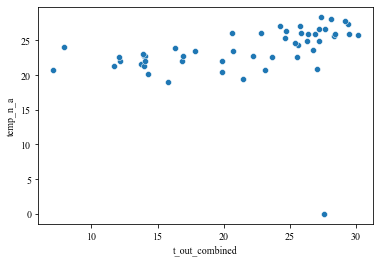

In [121]:
# Plot t_out_combined and temp_n_a data points in df_bldg_1_NV_office_a
sns.scatterplot(data=df_bldg_1_NV_office_a, x='t_out_combined', y='temp_n_a')
# Identifiy outliers of temp_n_a
outliers = df_bldg_1_NV_office_a[(df_bldg_1_NV_office_a['temp_n_a'] < 15) | (df_bldg_1_NV_office_a['temp_n_a'] > 30)]
outliers

In [ ]:
# remove the outliers
df_ACM_op_NV_a = df_bldg_1_NV_office_a.drop(outliers.index)

# Second Stage of ACM II

## Conduct weighted linear regression

In [170]:
def weighted_reg(x, y, weights):
    X = sm.add_constant(x)
    model = sm.WLS(y, X, weights=weights).fit()
    intercept, slope = model.params
    print('p value: {:.3f}'.format(model.pvalues[1]))
    print('MSE: {:.1f}'.format(np.mean(model.resid ** 2)))
    print('RMSE: {:.1f}'.format(np.sqrt(np.mean(model.resid ** 2))))
    print(model.summary())
    return intercept, slope

In [171]:
intercept, slope = weighted_reg(df_ACM_op_NV_a['t_out_combined'], df_ACM_op_NV_a['temp_n_a'], df_ACM_op_NV_a['records'])
# print the fitted line slope and intercept
print("******************************************************************************")
print('ACM regression line slope: {:.2f}'.format(slope))
print('ACM regression line intercept: {:.2f}'.format(intercept))
# calculate the mean range of 80% comfort zone
range = df_ACM_op_NV_a['temp_up_a'].mean() - df_ACM_op_NV_a['temp_low_a'].mean()
print('ACM 80% comfort zone: {:.2f}'.format(range))

p value: 0.000
MSE: 3.6
RMSE: 1.9
                            WLS Regression Results                            
Dep. Variable:               temp_n_a   R-squared:                       0.502
Model:                            WLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     48.35
Date:                Sat, 03 Feb 2024   Prob (F-statistic):           8.67e-09
Time:                        01:39:23   Log-Likelihood:                -102.43
No. Observations:                  50   AIC:                             208.9
Df Residuals:                      48   BIC:                             212.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const     

## Plot resulting ACM II

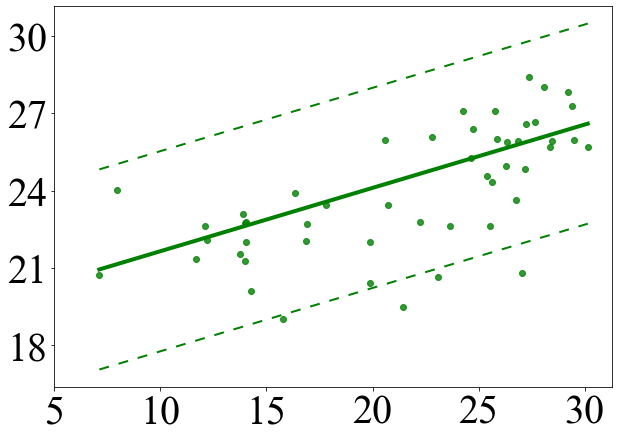

In [145]:
# sort the data points by t_out_combined
t_out = np.array(df_ACM_op_NV_a['t_out_combined'])
t_out = t_out[np.argsort(t_out)]
middle_line = slope * t_out + intercept
up_line = slope * t_out + intercept + range/2
low_line = slope * t_out + intercept - range/2

# middle_ASHRAE = 0.31 * t_out + 17.8
# up_ASHRAE = 0.31 * t_out + 17.8 + 3.5
# low_ASHRAE = 0.31 * t_out + 17.8 - 3.5

# plot data points
plt.figure(figsize=(10, 7))
sns.regplot(x='t_out_combined', y='temp_n_a', data=df_ACM_op_NV_a, fit_reg=False, scatter_kws={'color': 'green'})
plt.plot(t_out, middle_line, color='green', linewidth=4)
plt.plot(t_out, up_line, color='green', linewidth=2, linestyle='--', dashes=(5, 5))
plt.plot(t_out, low_line, color='green', linewidth=2, linestyle='--', dashes=(5, 5))

# plt.plot(t_out, middle_ASHRAE, color='black', linewidth=4)
# plt.plot(t_out, up_ASHRAE, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
# plt.plot(t_out, low_ASHRAE, color='black', linewidth=2, linestyle='--', dashes=(5, 5))

plt.xlabel('', fontsize=40)
plt.ylabel('', fontsize=40)
plt.xticks(np.arange(5, 33, 5), fontsize=40)
plt.yticks(np.arange(18, 33, 3), fontsize=40)
plt.grid(False)
plt.rcParams['font.family'] = 'Times New Roman'
plt.savefig('figs/fig3_a.pdf', format='pdf', bbox_inches='tight')

# Evidence 1:

In [147]:
def accuracy(slope, intercept, range, df, temp):
    """
    Calculate the accuracy of a ACM model based on the df, using a calssification method.
    If the temp is in the comfort zone and TSV is in +-0.85, then it is classified as 1, or
    If the temp is out of the comfort zone and TSV is out of the 0.85, then it is classified as 1, or
    If the temp is below the comfort zone and TSV is smaller than 0.85, then it is classified as 1, otherwies 0.
    Count the percentage of 1 over total records in df as the prediction accuracy.
    """
    df.count = np.where(
        # Case 1: Comfortable when within range
        ((df.thermal_sensation >= -0.85) & 
        (df.thermal_sensation <= 0.85) & 
        (df[temp] >= df.t_out_combined * slope + intercept - range/2) & 
        (df[temp] <= df.t_out_combined * slope + intercept + range/2)) |
        # Case 2: Uncomfortable cool when lower the range
        ((df.thermal_sensation < -0.85) & (df[temp] < df.t_out_combined * slope + intercept - range/2))| 
        # Case 3: Uncomfortable warm when higher the range
        ((df.thermal_sensation > 0.85) & (df[temp] > df.t_out_combined * slope + intercept + range/2)),
        1,  # Accurate prediction
        0)   # Inaccurate prediction
    accuracy = len(df[df.count == 1])/len(df)
    return accuracy

## Prepare data for prediction accuracy

In [173]:
# Reset the building cooling type as string, ensuring direct modification of the DataFrame
df_data_1 = df_data_1.copy()
df_data_1['cooling_type'] = df_data_1['cooling_type'].str.title()

# Filter for office buildings with naturally ventilated cooling
df_bldg_1_NV = df_bldg_1[df_bldg_1['cooling_type'] == 'Naturally Ventilated']
df_data_1_NV = df_data_1[df_data_1['cooling_type'] == 'Naturally Ventilated']
print(f'NV buildings without missing data:', len(df_bldg_1_NV))
print(f'NV building occupants without missing data:', len(df_data_1_NV))

# Filter for office buildings with naturally ventilated cooling
df_bldg_1_NV_office = df_bldg_1_NV[df_bldg_1_NV['building_type'] == 'office']
df_data_1_NV_office = df_data_1_NV[df_data_1_NV['building_type'] == 'office']
print(f'NV office buildings without missing data:', len(df_bldg_1_NV_office))
print(f'NV office building occupants without missing data:', len(df_data_1_NV_office))

NV buildings without missing data: 216
NV building occupants without missing data: 19685
NV office buildings without missing data: 67
NV office building occupants without missing data: 15330


## ASHRAE ACM prediction accuracy

In [174]:
slope = 0.31
intercept = 17.8
range = 7

result = 100 * accuracy(slope, intercept, range, df_data_1_NV_office, 'top')
print('All TSV prediction accraucy, NV office building: {:.0f} %'.format(result))
result = 100 * accuracy(slope, intercept, range, df_data_1_NV, 'top')
print('All TSV prediction accraucy, NV building: {:.0f} %'.format(result))

result = 100 * accuracy(slope, intercept, range, df_bldg_1_NV_office, 'top')
print('Mean TSV prediction accraucy, NV office building: {:.0f} %'.format(result))
result = 100 * accuracy(slope, intercept, range, df_bldg_1_NV, 'top')
print('Mean TSV prediction accraucy, NV building: {:.0f} %'.format(result))


All TSV prediction accraucy, NV office building: 53 %
All TSV prediction accraucy, NV building: 50 %
Mean TSV prediction accraucy, NV office building: 70 %
Mean TSV prediction accraucy, NV building: 55 %


## ACM II prediction accuracy

In [175]:
slope = 0.25
intercept = 19.19
range = 7.77

result = 100 * accuracy(slope, intercept, range, df_data_1_NV_office, 'top')
print('All TSV prediction accraucy, NV office building: {:.0f} %'.format(result))
result = 100 * accuracy(slope, intercept, range, df_data_1_NV, 'top')
print('All TSV prediction accraucy, NV building: {:.0f} %'.format(result))

result = 100 * accuracy(slope, intercept, range, df_bldg_1_NV_office, 'top')
print('Mean TSV prediction accraucy, NV office building: {:.0f} %'.format(result))
result = 100 * accuracy(slope, intercept, range, df_bldg_1_NV, 'top')
print('Mean TSV prediction accraucy, NV building: {:.0f} %'.format(result))

All TSV prediction accraucy, NV office building: 53 %
All TSV prediction accraucy, NV building: 49 %
Mean TSV prediction accraucy, NV office building: 66 %
Mean TSV prediction accraucy, NV building: 54 %


## Optimization slope, intercept and range

In [ ]:
# create a list to store the results
results = []
for slope in np.arange(-3, 3, 0.1):
    for intercept in np.arange(10, 20, 0.1):
        for range in np.arange(0, 10, 0.1):
            accuracy_NV = accuracy(slope, intercept, range, df_data_1_NV, 'top')
            accuracy_NV_office = accuracy(slope, intercept, range, df_data_1_NV_office, 'top')
            accuracy_NV_mean = accuracy(slope, intercept, range, df_bldg_1_NV, 'top')
            accuracy_NV_office_mean = accuracy(slope, intercept, range, df_bldg_1_NV_office, 'top')
            results.append({'Slope': slope, 
                            'Intercept': intercept, 
                            'Range': range, 
                            'Accuracy_NV': accuracy_NV,
                            'Accuracy_NV_office': accuracy_NV_office,
                            'Accuracy_NV_mean': accuracy_NV_mean,
                            'Accuracy_NV_office_mean': accuracy_NV_office_mean})
results_df = pd.DataFrame(results)

In [176]:
results_df

NameError: name 'results_df' is not defined

# Evidence 2: